<a href="https://colab.research.google.com/github/Kalyankr/Tensorflow_2.0-image-classification/blob/master/Image_classificaion_with_TF_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle

In [0]:
!mkdir .kaggle
import json

token = {"username":"kalyankkr","key":"eb4490a97832b774a42f565f017cf9ee"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          23229  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          17338  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          18921  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           3643  
lava18/google-play-store-apps                             

**DATA**

In [0]:
# Download dataset
!mkdir -p data
!kaggle competitions download -c aerial-cactus-identification -p data

  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 43.3MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 47.2MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 68.5MB/s]
 42% 8.00M/19.2M [00:00<00:00, 81.5MB/s]
100% 19.2M/19.2M [00:00<00:00, 123MB/s] 


In [0]:
# Unzip dataset
!unzip data/train.zip -d data
!unzip data/test.zip -d data

# Install **TENSORFLOW 2.0**

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 72kB/s 
    100% |████████████████████████████████| 3.0MB 8.8MB/s 
    100% |████████████████████████████████| 419kB 13.4MB/s 
    100% |████████████████████████████████| 61kB 24.1MB/s 


In [0]:
import tensorflow as tf 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
print(tf.__version__)

2.0.0-alpha0


In [0]:
train=pd.read_csv("data/train.csv")
print(train.describe())
print(train.head())

         has_cactus
count  17500.000000
mean       0.750629
std        0.432662
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


**Dispay images**

Cactus


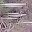

NOT cactus


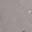

In [0]:
print("Cactus")
display(Image("data/train/0004be2cfeaba1c0361d39e2b000257b.jpg"))
print("NOT cactus")
display(Image('data/train/ffede47a74e47a5930f81c0b6896479e.jpg'))

In [0]:
filenames=["data/train/"+ fname for fname in train["id"].tolist()]
labels=train["has_cactus"].tolist()

train_fnames,val_fnames,train_labels,val_labels=train_test_split(filenames,labels,train_size=0.9,random_state=42)

num_train=len(train_fnames)
num_val=len(val_fnames)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Decoding the images

In [0]:
Image_size=96


def _parse_fn(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
  image_resized = tf.image.resize(image_normalized, (Image_size, Image_size))
  return image_resized, label

In [0]:
BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_fnames), tf.constant(train_labels))).map(_parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE)


val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_fnames), tf.constant(val_labels))).map(_parse_fn).batch(BATCH_SIZE)

**Model MobileNetV2**

In [0]:
img_shape=(Image_size,Image_size,3)

base_model=tf.keras.applications.MobileNetV2(input_shape=img_shape,include_top=False,
                                           weights="imagenet")
base_model.trainable=False

9412608/9406464 [==============================] - 0s 0us/step


Final layers for mobilenetV2
Adding Globalmax pooling and Output Dense layer 

In [0]:
maxpool_layer=tf.keras.layers.GlobalMaxPooling2D()
prediction_layer=tf.keras.layers.Dense(1,activation="sigmoid")

In [0]:
learning_rate= 0.1**4

model= tf.keras.Sequential([base_model,maxpool_layer,prediction_layer])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss="binary_crossentropy",metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
#Train

num_epochs=30
steps_per_epoch=round(num_train)//BATCH_SIZE
val_steps=20

In [0]:
history=model.fit(train_data.repeat(),epochs=num_epochs,steps_per_epoch=steps_per_epoch,validation_data=val_data.repeat(),validation_steps=val_steps)

Epoch 1/30
492/492 [==============================] - 34s 70ms/step - loss: 0.3877 - accuracy: 0.8441 - val_loss: 0.4893 - val_accuracy: 0.7703
Epoch 2/30
492/492 [==============================] - 28s 56ms/step - loss: 0.2037 - accuracy: 0.9200 - val_loss: 0.3917 - val_accuracy: 0.8188
Epoch 3/30
492/492 [==============================] - 26s 52ms/step - loss: 0.1690 - accuracy: 0.9352 - val_loss: 0.2971 - val_accuracy: 0.8625
Epoch 4/30
492/492 [==============================] - 27s 55ms/step - loss: 0.1497 - accuracy: 0.9426 - val_loss: 0.2306 - val_accuracy: 0.9078
Epoch 5/30
492/492 [==============================] - 25s 52ms/step - loss: 0.1346 - accuracy: 0.9488 - val_loss: 0.2062 - val_accuracy: 0.9094
Epoch 6/30
492/492 [==============================] - 27s 55ms/step - loss: 0.1230 - accuracy: 0.9520 - val_loss: 0.2367 - val_accuracy: 0.8906
Epoch 7/30
492/492 [==============================] - 26s 52ms/step - loss: 0.1212 - accuracy: 0.9519 - val_loss: 0.1490 - val_accuracy:

In [0]:
# Save model weights
model.save_weights('weights_epoch_30.h5')

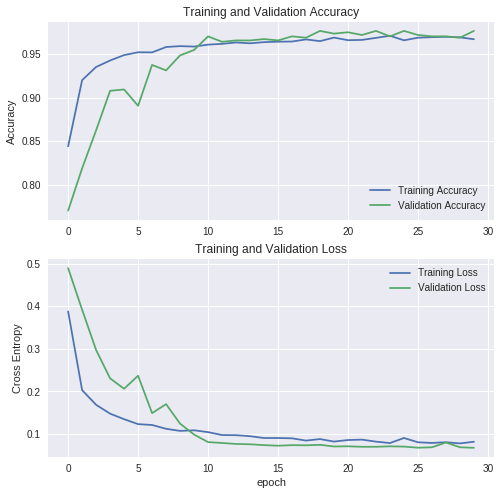

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# Unfreeze all layers of MobileNetV2
base_model.trainable = True

# Refreeze layers until the layers we want to fine-tune
for layer in base_model.layers[:100]:
  layer.trainable =  False


**Fine tuning**

In [0]:


model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=learning_rate/10),
              metrics=['accuracy'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
fine_tune_epochs = 30
total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_data.repeat(), 
                         steps_per_epoch = steps_per_epoch,
                         epochs=total_epochs, 
                         initial_epoch = num_epochs,
                         validation_data=val_data.repeat(), 
                         validation_steps=val_steps)

Epoch 31/60
492/492 [==============================] - 55s 113ms/step - loss: 0.0647 - accuracy: 0.9757 - val_loss: 0.0507 - val_accuracy: 0.9797
Epoch 32/60
492/492 [==============================] - 37s 76ms/step - loss: 0.0509 - accuracy: 0.9815 - val_loss: 0.0448 - val_accuracy: 0.9812
Epoch 33/60
492/492 [==============================] - 36s 73ms/step - loss: 0.0404 - accuracy: 0.9857 - val_loss: 0.0394 - val_accuracy: 0.9906
Epoch 34/60
492/492 [==============================] - 36s 72ms/step - loss: 0.0310 - accuracy: 0.9894 - val_loss: 0.0308 - val_accuracy: 0.9891
Epoch 35/60
492/492 [==============================] - 38s 77ms/step - loss: 0.0244 - accuracy: 0.9917 - val_loss: 0.0271 - val_accuracy: 0.9937
Epoch 36/60
492/492 [==============================] - 36s 73ms/step - loss: 0.0191 - accuracy: 0.9934 - val_loss: 0.0225 - val_accuracy: 0.9922
Epoch 37/60
492/492 [==============================] - 36s 72ms/step - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.0230 - val_a

In [0]:
# Save fine-tuned model weights
model.save_weights('weights_epoch_50_finetuned.h5')

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

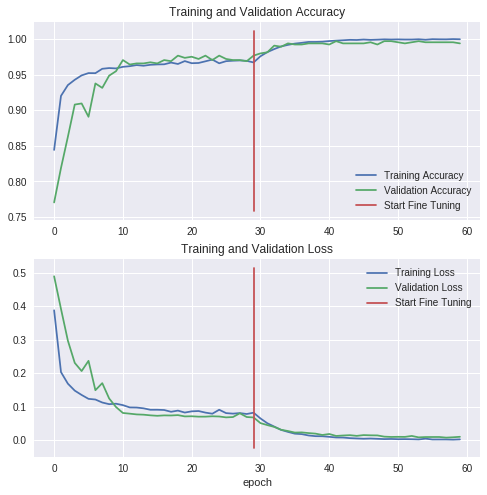

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([num_epochs-1,num_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([num_epochs-1,num_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()